In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
import sklearn, sklearn.metrics

import glob
import captum
import latentshift
import classifiers
import ct_models
import ct_datasets

/tmp/ipykernel_151986/1991387906.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = 'cuda'

In [4]:
model = classifiers.phecode.PheCodeClassifier().to(device)

Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [160]:
weights_path = '/home/groups/akshaysc/joecohen/weights/'
ae_folder = '2023-07-27T19-35-51_ct_vqgan_sdd'
ae_folder = '2023-12-25T10-26-40_ct2_vqgan256_sddd'
ae = ct_models.VQGAN(
    ckpt_path=f'{weights_path}/{ae_folder}/checkpoints/last.ckpt',
    yaml_path=glob.glob(f'{weights_path}/{ae_folder}/configs/*-project.yaml')[0],
    resize=256,
).to(device)

Working with z of shape (1, 256, 4, 4) = 4096 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [161]:
!ls /home/users/joecohen/group/phecode_scans/pacemaker/

AC423c71a_0000.nii.gz  AC4240355_0000.nii.gz  AC4242a48_0000.nii.gz
AC423d550_0000.nii.gz  AC4240711_0000.nii.gz  AC424343e_0000.nii.gz
AC423efff_0000.nii.gz  AC42409a7_0000.nii.gz  isolated_scans.zip
AC4240174_0000.nii.gz  AC4240d86_0000.nii.gz  __MACOSX


In [162]:
data = ct_datasets.NIFTI_Dataset('/home/users/joecohen/group/phecode_scans/pain_cases/AC4214770_0000', 
                                resolution=256)

In [163]:
img = data[0]['image'][None,...]
img.shape

torch.Size([1, 1, 256, 256, 160])

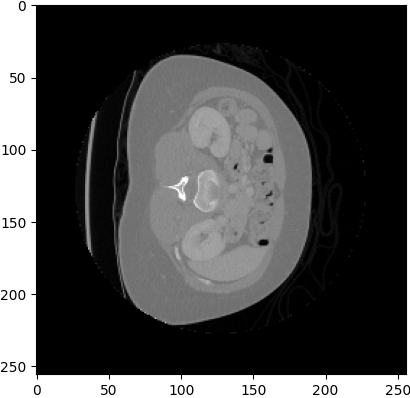

In [164]:
plt.imshow(img[0,0,:,:,100], cmap='gray');

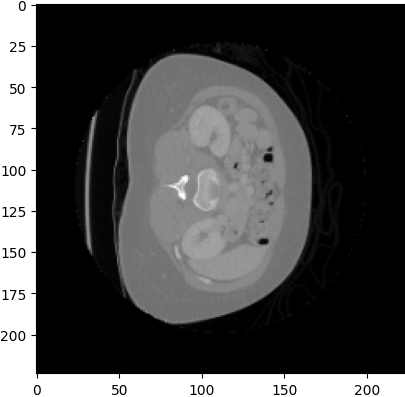

In [165]:
x = img[:,:,:,:,100]
x = torch.from_numpy(ct_datasets.Resize(224)(x[0,0])[None,None])
plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray');

In [166]:
z = ae.encode(x.cuda())

In [167]:
img2 = ae.decode(z)

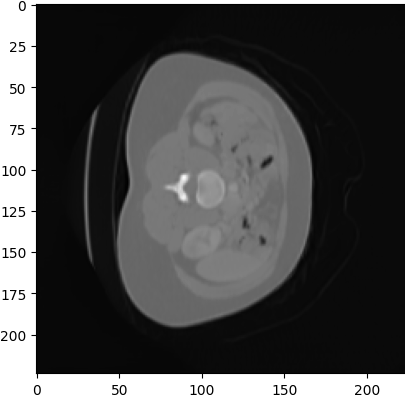

In [168]:
plt.imshow(img2[0][0].cpu().detach().numpy(), cmap='gray');

In [169]:
np.asarray(model.targets)[['pain' in target for target in model.targets]]

array(['Acute pain', 'Chronic pain',
       'Complex regional/central pain syndrome', 'Chronic pain syndrome',
       'Nonspecific chest pain', 'Precordial pain', 'Throat pain',
       'Back pain', 'Abdominal pain'], dtype='<U120')

In [170]:
np.asarray(model.targets)[['pace' in target for target in model.targets]]

array(['Swelling, mass, or lump in head and neck [Space-occupying lesion, intracranial NOS]',
       'Cardiac pacemaker/device in situ', 'Cardiac pacemaker in situ'],
      dtype='<U120')

In [171]:
attr = captum.attr.LatentShift(
    latentshift.alignment.ModelWrapper(
        model, 
        target='Abdominal pain', 
        rename_model='', sigmoid=True), 
    ct_models.SliceAEFull(ae, 105,115),
)
output = attr.attribute(img.cuda(), target=0,
                        #fix_range=[-180000,0], 
                        return_dicts = True,
                        apply_sigmoid = False,
                        search_max_steps = 30000,
                       )[0]
#plt.imshow(output['heatmap'][0]);

Shift: 0, Pred: 0.7474161982536316, pixel_diff: 0.0, sum*diff_pct: 86350.40625
Shift: -10.0, Pred: 0.7472566366195679, pixel_diff: 8.273138999938965, sum*diff_pct: 86350.40625
Shift: -21.0, Pred: 0.747086763381958, pixel_diff: 17.376482009887695, sum*diff_pct: 86350.40625
Shift: -34.0, Pred: 0.7468861937522888, pixel_diff: 28.170040130615234, sum*diff_pct: 86350.40625
Shift: -48.0, Pred: 0.7466723322868347, pixel_diff: 39.78571319580078, sum*diff_pct: 86350.40625
Shift: -63.0, Pred: 0.7464472055435181, pixel_diff: 52.21033477783203, sum*diff_pct: 86350.40625
Shift: -80.0, Pred: 0.746246874332428, pixel_diff: 66.24864196777344, sum*diff_pct: 86350.40625
Shift: -98.0, Pred: 0.746097207069397, pixel_diff: 81.07273864746094, sum*diff_pct: 86350.40625
Shift: -118.0, Pred: 0.7459200620651245, pixel_diff: 97.45458221435547, sum*diff_pct: 86350.40625
Shift: -140.0, Pred: 0.7457603812217712, pixel_diff: 115.42955780029297, sum*diff_pct: 86350.40625
Shift: -164.0, Pred: 0.7456267476081848, pixel

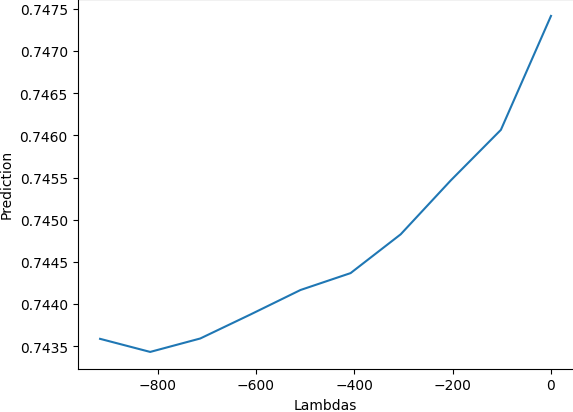

In [172]:
plt.plot(output['lambdas'],output['preds']);
plt.xlabel('Lambdas');
plt.ylabel('Prediction');

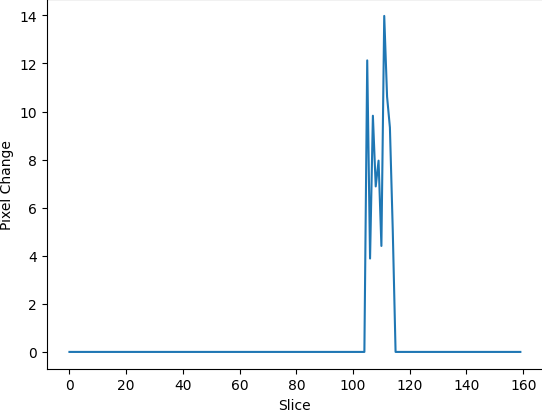

In [173]:
plt.plot(np.abs(output['heatmap']).sum(0).sum(0).sum(0));
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

In [174]:
output['heatmap'].shape

(1, 256, 256, 160)

In [175]:
idx = output['heatmap'].sum(1).sum(1).argmax()
idx

111

In [176]:
idx = 113

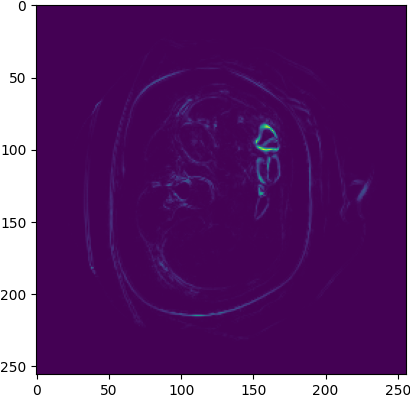

In [177]:
plt.imshow(output['heatmap'][0,:,:,idx]);

In [178]:
images = [output['generated_images'][i, :,:,:,idx] for i in range(len(output['generated_images']))]

In [179]:
images[0].shape

(1, 256, 256)

In [180]:
np.asarray(images).mean((1,2,3))

array([0.3300573 , 0.33004564, 0.3300339 , 0.33002245, 0.33001095,
       0.3299991 , 0.3299871 , 0.3299749 , 0.32996237, 0.32994935],
      dtype=float32)

In [181]:
latentshift.video_utils.generate_video({'generated_images':images, 'preds':output['preds']}, "test", show_pred=True, watermark=False, cmap='gray', 
                                       extra_loops=0,
                                      ffmpeg_path='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg',
                                      resize=512)


/share/software/user/open/ffmpeg/5.0/bin/ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:512 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=   20 fps=0.0 q=-1.0 Lsize=      13kB time=00:00:00.76 bitrate= 143.4kbits/s speed=6.18x    


In [182]:
outputs = []
batch_size = 15
for i in range(0, img.shape[-1], batch_size):
    print(f'Slices {i}-{i+batch_size}')
    attr = captum.attr.LatentShift(
        latentshift.alignment.ModelWrapper(
            model, 
            target='Abdominal pain',
            #adjustment=lambda x: x+8, 
            rename_model='', sigmoid=True),
        ct_models.SliceAEFull(ae, i, i+batch_size)
    )
    output = attr.attribute(img.cuda(), target=0,
                            #fix_range=[-700,0],
                            return_dicts = True,
                            apply_sigmoid = False,
                            lambda_sweep_steps = 2,
                            search_max_steps = 20000,
                            verbose=False,
                           )[0]
    outputs.append(output)

Slices 0-15
Slices 15-30
Slices 30-45
Slices 45-60
Slices 60-75
Slices 75-90
Slices 90-105
Slices 105-120
Slices 120-135
Slices 135-150
Slices 150-165


In [183]:
len(outputs)

11

In [184]:
pred_changes = np.concatenate([[np.min(o['preds'])]*batch_size for o in outputs])

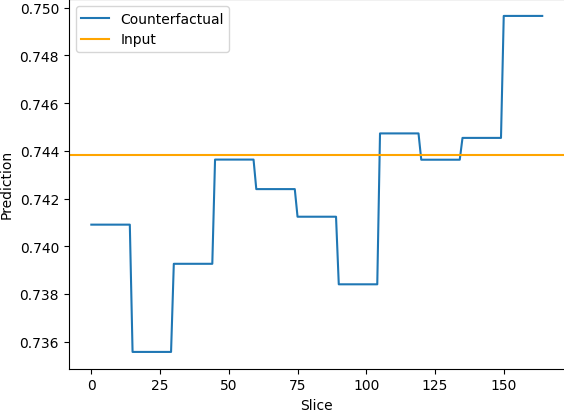

In [185]:
plt.plot(pred_changes, label='Counterfactual');
plt.axhline(outputs[0]['preds'][-1], label='Input', c='orange')
plt.xlabel('Slice');
plt.ylabel('Prediction');
plt.legend();

In [186]:
heatmaps = np.concatenate([o['heatmap'] for o in outputs], 3)

In [187]:
raw_diffs = np.concatenate([np.abs(o['heatmap']).sum(0).sum(0).sum(0) for o in outputs])
diffs = raw_diffs[raw_diffs != 0]

In [188]:
heatmaps1 = heatmaps[:,:,:,raw_diffs != 0]

In [189]:
images_reconstruction = np.concatenate([o['generated_images'][-1] for o in outputs], 3)
images_counterfactual = np.concatenate([o['generated_images'][0] for o in outputs], 3)

In [190]:
images_reconstruction = images_reconstruction[...,raw_diffs != 0]
images_counterfactual = images_counterfactual[...,raw_diffs != 0]

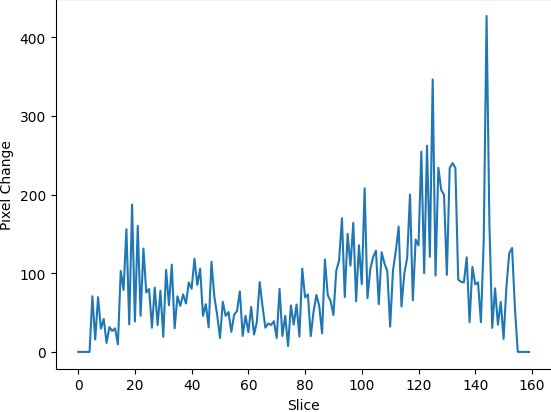

In [191]:
plt.plot(diffs);
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

In [192]:
lines

[[<matplotlib.lines.Line2D at 0x7f97f9cbca90>],

(0.0, 148.0)

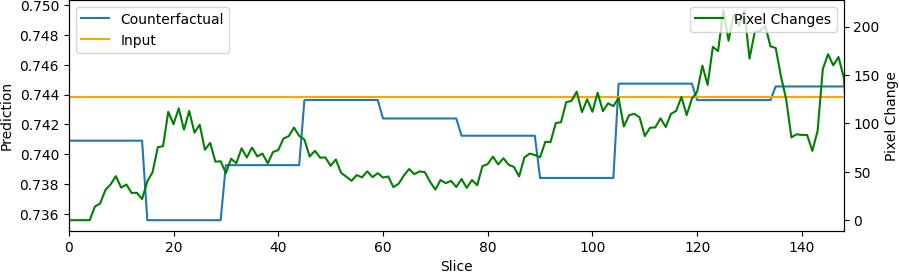

In [211]:
plt.figure(figsize=(10,3))
lines = []
lines.append(plt.plot(pred_changes, label='Counterfactual'))
lines.append([plt.axhline(outputs[0]['preds'][-1], label='Input', c='orange')])
plt.ylabel('Prediction');
plt.legend(loc='upper left')
plt.xlabel('Slice');
#plt.ylim()

plt.twinx()

xnew = np.linspace(0, len(diffs), len(diffs)) 
smoothed_diffs = np.convolve(diffs, np.ones(5)/5, mode='full')
lines.append(plt.plot(smoothed_diffs, label='Pixel Changes', c='green'))
plt.xlabel('Slice');
plt.ylabel('Pixel Change');
plt.legend();
plt.legend(loc='upper right')
plt.xlim(0,148)
# # added these three lines
# lns = [l[0] for l in lines]
# labs = [l[0].get_label() for l in lines]
# plt.legend(lns, labs, loc='right',  bbox_to_anchor=(1.3, 0.5));


In [194]:
np.argmax(diffs)

144

In [195]:
np.argmax(-pred_changes)

15

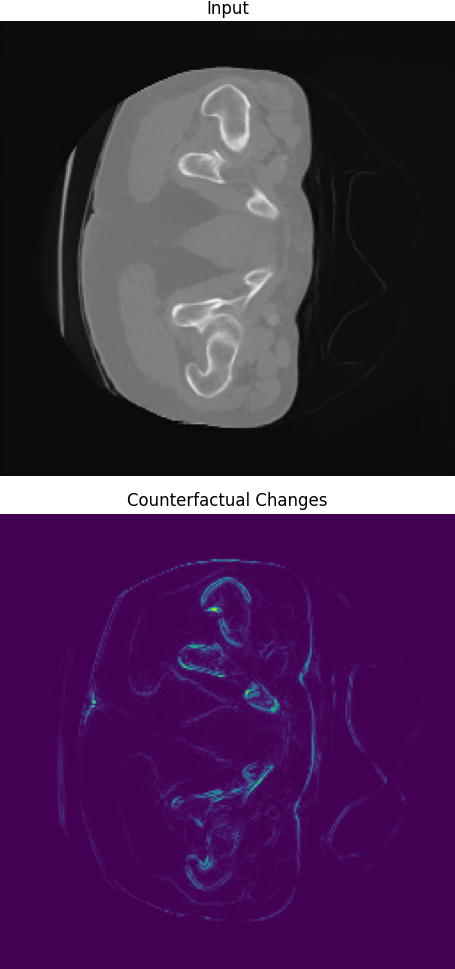

In [206]:
idx_slice = 23
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0,:,:,idx_slice], cmap='gray')
axs[0].set_title('Input')
axs[0].axis('off') 
# axs[1].imshow(images_counterfactual[0,:,:,idx_slice], cmap='gray')
# axs[1].set_title('Counterfactual')
# axs[1].axis('off') 
axs[1].imshow(heatmaps1[0,:,:,idx_slice])
axs[1].set_title('Counterfactual Changes');
axs[1].axis('off') 
plt.tight_layout()


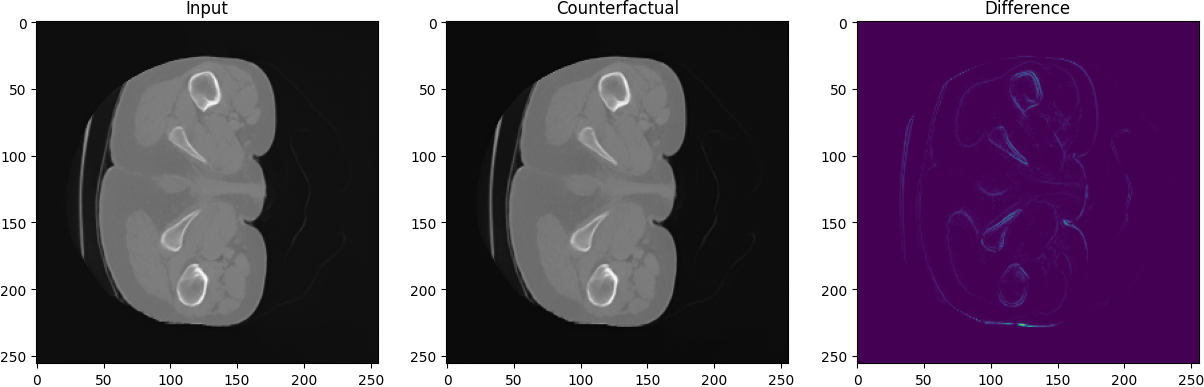

In [197]:
idx_slice = 15
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0,:,:,idx_slice], cmap='gray')
axs[0].set_title('Input')
axs[1].imshow(images_counterfactual[0,:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual')
axs[2].imshow(heatmaps1[0,:,:,idx_slice])
axs[2].set_title('Difference');

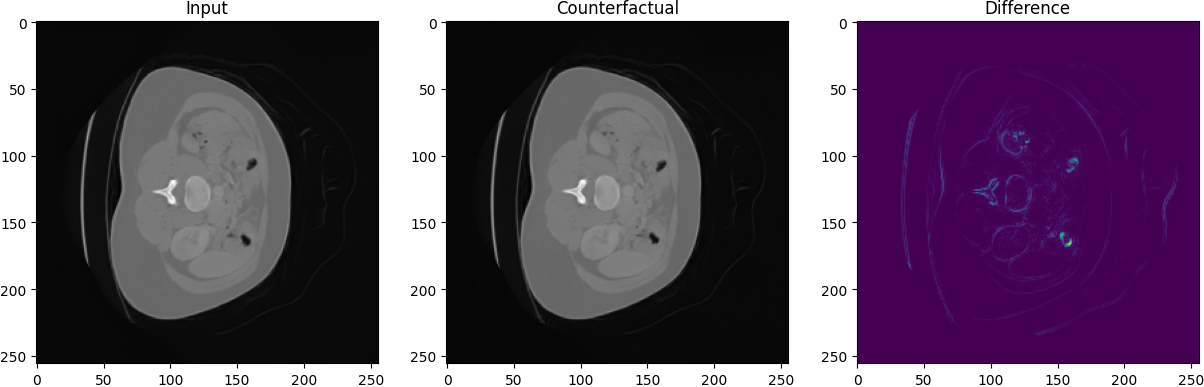

In [198]:
idx_slice = 100
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0,:,:,idx_slice], cmap='gray')
axs[0].set_title('Input')
axs[1].imshow(images_counterfactual[0,:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual')
axs[2].imshow(heatmaps1[0,:,:,idx_slice])
axs[2].set_title('Difference');

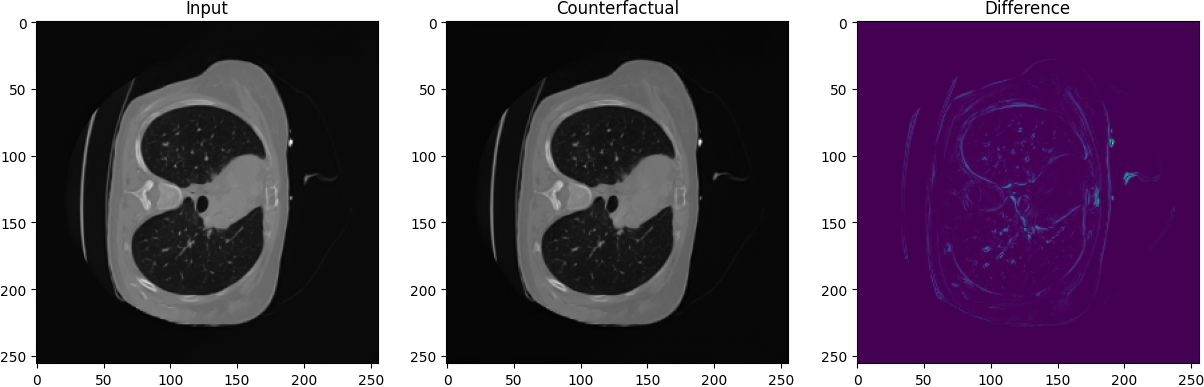

In [199]:
idx_slice = 145
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0,:,:,idx_slice], cmap='gray')
axs[0].set_title('Input')
axs[1].imshow(images_counterfactual[0,:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual')
axs[2].imshow(heatmaps1[0,:,:,idx_slice])
axs[2].set_title('Difference');